## EDA, identify anomalies
analyze time series describing different types of anomalies comparing with manual correction channel

### Table of contents

- [Open and check the data](#step1)
  
- [Anomaly detection: naive method, IQR. Velocity & Level](#step2)

- [Anomaly detection: ARIMA. Velocity](#step3)

- [Anomaly detection: Prophet. Velocity.](#step4)

- [Conclusions](#step7)

#### Open and check the data<a name="step1"></a>

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

In [2]:
#read the data
level = pd.read_csv('level.csv')
level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350784 entries, 0 to 350783
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         350784 non-null  object 
 1   level        350784 non-null  float64
 2   final_level  329984 non-null  float64
dtypes: float64(2), object(1)
memory usage: 8.0+ MB


In [3]:
#read the data
velocity = pd.read_csv('velocity.csv')
velocity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350784 entries, 0 to 350783
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   time            350784 non-null  object 
 1   velocity        350679 non-null  float64
 2   final_velocity  329984 non-null  float64
dtypes: float64(2), object(1)
memory usage: 8.0+ MB


In [4]:
#merge the two df 
total = velocity.merge(level, left_on="time",
    right_on="time", how='left' )
total.head()

,time,velocity,final_velocity,level,final_level
0,2014-09-01 00:00:00,0.8883,0.8883,74.529999,74.529999
1,2014-09-01 00:05:00,0.8856,0.8856,75.029999,75.029999
2,2014-09-01 00:10:00,0.8379,0.8379,74.300003,74.300003
3,2014-09-01 00:15:00,0.8514,0.8514,74.309998,74.309998
4,2014-09-01 00:20:00,0.8487,0.8487,80.050003,80.050003


In [5]:
total.shape

(350784, 5)

### Anomaly detection: naive method, IQR<a name="step2"></a>

In [5]:
# identify outliers, which are possibly anomalies
# IQR method (the interquartile range)

Q1 = total.quantile(0.25)
Q3 = total.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

velocity           0.279000
final_velocity     0.247500
level             15.519997
final_level       15.370003
dtype: float64


In [7]:
Q1

velocity           0.674100
final_velocity     0.710100
level             75.760002
final_level       75.290001
Name: 0.25, dtype: float64

In [6]:
outliers = total[((total < (Q1 - 1.5 * IQR)) |(total > (Q3 + 1.5 * IQR))).any(axis=1)]
outliers.shape

(17233, 5)

In [9]:
print("There are {}% of the outliers in the data".format(round((outliers.shape[0])/total.shape[0]*100 ,0)))

There are 5.0% of the outliers in the data


In [11]:
outliers.describe()

,velocity,final_velocity,level,final_level
count,17185.000000,8731.000000,17233.000000,8731.000000
mean,0.544300,0.648875,118.645310,118.708237
std,0.163921,0.151219,14.679730,10.227260
min,0.020700,0.140400,20.260000,20.260000
25%,0.452700,0.562500,116.370003,115.774998
50%,0.505800,0.653400,119.779999,118.730003
75%,0.658800,0.749700,124.519997,123.129997
max,1.325700,1.325700,153.320007,153.320007


In [12]:
outliers.head()

,time,velocity,final_velocity,level,final_level
6649,2014-09-24 02:05:00,0.3159,0.3159,60.66,60.66
14987,2014-10-23 00:55:00,0.3564,0.3564,20.26,20.26
15026,2014-10-23 04:10:00,0.3555,0.3555,20.26,20.26
15027,2014-10-23 04:15:00,0.2682,0.2682,20.26,20.26
15028,2014-10-23 04:20:00,0.2628,0.2628,24.91,24.91


In [7]:
#change to datetime
total['time'] = pd.to_datetime(total["time"])
outliers['time'] = pd.to_datetime(outliers["time"])

C:\Users\nadye\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Plot ***level***

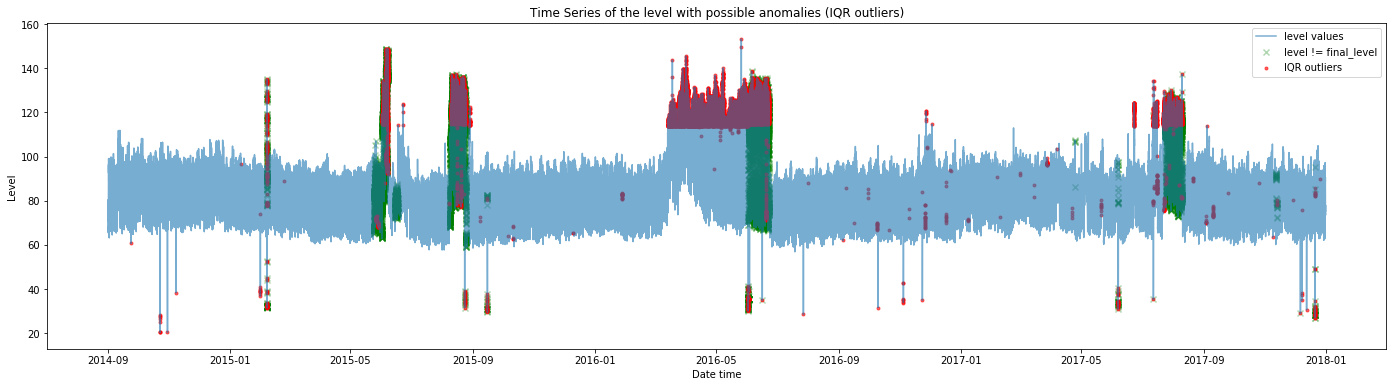

In [17]:
'''plot initial values with marked outliers'''
'''level, total data'''

pd.plotting.register_matplotlib_converters()  # needed to plot timestamps


plt.subplots(figsize=(24,6))

plt.plot(total.time, total.level, alpha=0.6, label="level values") 
plt.scatter("time", "level", data=total[total.level!=total.final_level], 
              marker="x", color='green', label="level != final_level", alpha=0.3) #manually corrected values
plt.scatter(x='time', y='level', data=outliers, 
            marker=".", color='red', label="IQR outliers", alpha=0.6) # iqr outliers(anomalies)

plt.xlabel('Date time')
plt.ylabel('Level')
plt.title('Time Series of the level with possible anomalies (IQR outliers)');
plt.legend(loc="best")
plt.show()

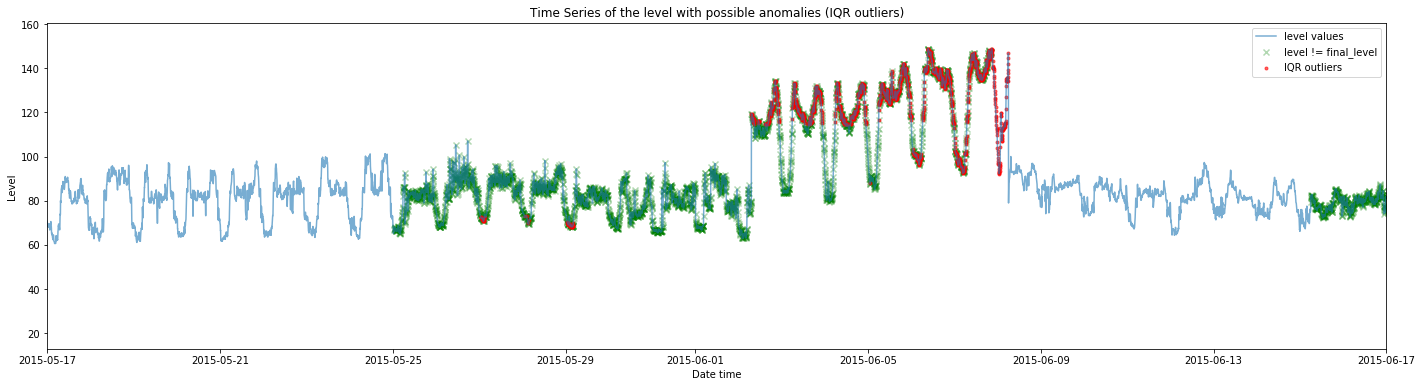

In [18]:
'''plot initial values with possible data loss or inconsistency'''
'''detailed view, 1 random month, where level!=final_level'''
'''level'''

pd.plotting.register_matplotlib_converters()  # needed to plot timestamps
plt.subplots(figsize=(24,6))

plt.plot(total.time, total.level,alpha=0.6, label="level values")
plt.scatter("time", "level", data=total[total.level!=total.final_level], 
              marker="x", color='green', label="level != final_level", alpha=0.3)#
plt.scatter(x='time', y='level', data=outliers, marker=".",
            color='red', label="IQR outliers", alpha=0.6)
plt.xlim('2015-05-17 00:00:00','2015-06-17 00:00:00') #adjustable
plt.xlabel('Date time')
plt.ylabel('Level')
plt.title('Time Series of the level with possible anomalies (IQR outliers)');
plt.legend(loc="best");

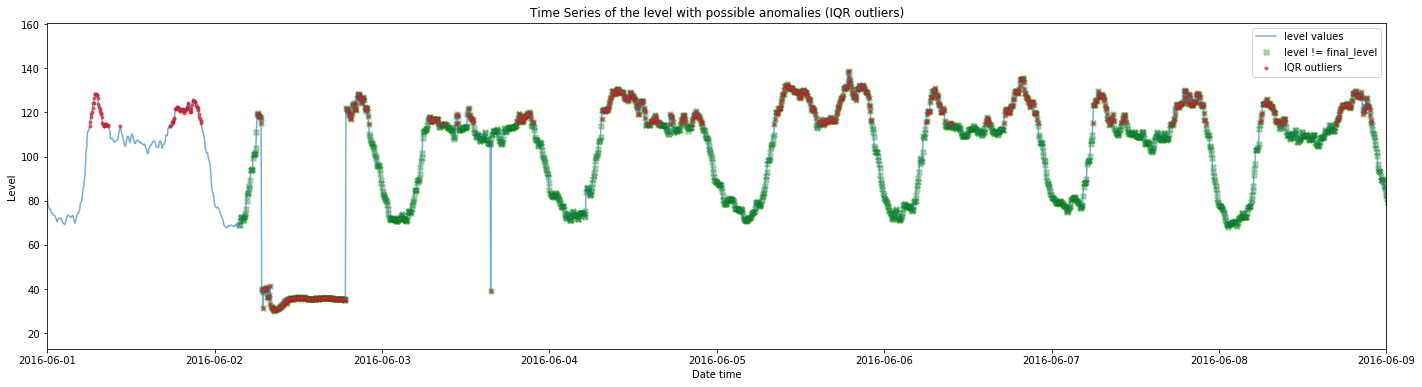

In [19]:
'''plot initial values with possible data loss or inconsistency'''
'''detailed view, 1 random week, where level!=final_level'''
'''level'''

plt.subplots(figsize=(24,6))

plt.plot(total.time, total.level, alpha=0.6, label="level values")
plt.scatter("time", "level", data=total[total.level!=total.final_level], 
              marker="X", color='green', label="level != final_level", alpha=0.3)#
plt.scatter(x='time', y='level', data=outliers,  marker=".",
            color='red', label="IQR outliers", alpha=0.6)
plt.xlim('2016-06-01 00:00:00','2016-06-09 00:00:00') #adjustible
plt.xlabel('Date time')
plt.ylabel('Level')
plt.title('Time Series of the level with possible anomalies (IQR outliers)');
plt.legend(loc="best");

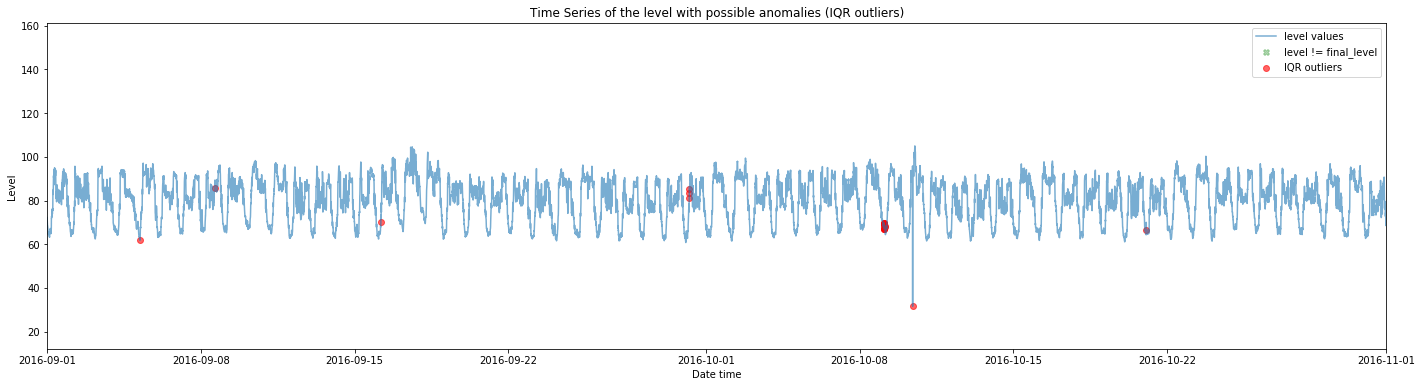

In [20]:
'''plot initial values with possible data loss or inconsistency'''
'''detailed view, 1 random week, where level!=final_level'''
'''level'''

plt.subplots(figsize=(24,6))

plt.plot(total.time, total.level, alpha=0.6, label="level values")
plt.scatter("time", "level", data=total[total.level!=total.final_level], 
              marker="X", color='green', label="level != final_level", alpha=0.3)#
plt.scatter(x='time', y='level', data=outliers,  marker="o",
            color='red', label="IQR outliers", alpha=0.6)
plt.xlim('2016-09-01 00:00:00','2016-11-01 00:00:00') #adjustable
plt.xlabel('Date time')
plt.ylabel('Level')
plt.title('Time Series of the level with possible anomalies (IQR outliers)');
plt.legend(loc="best");

#### Plot ***velocity***

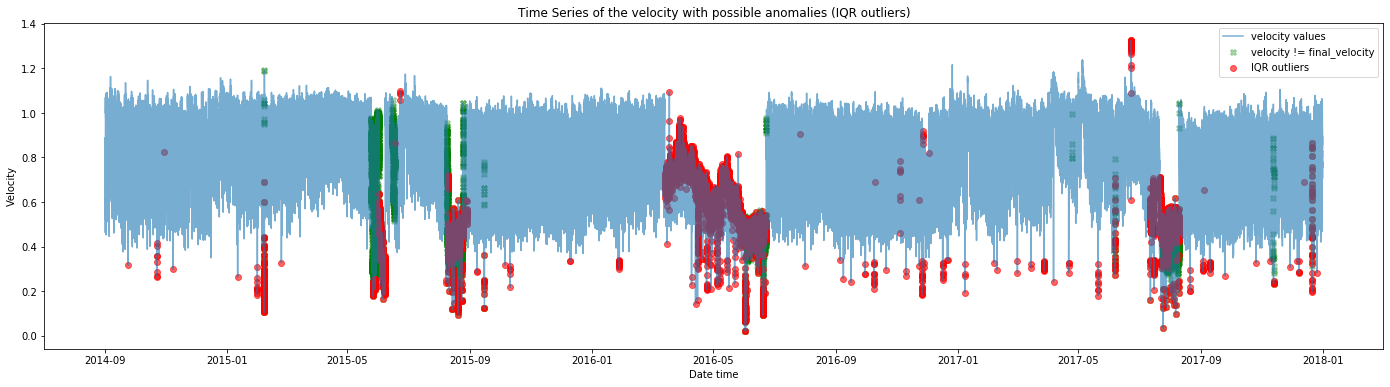

In [21]:
'''plot initial values with marked outliers'''
'''velocity, total data'''

pd.plotting.register_matplotlib_converters()  # needed to plot timestamps


plt.subplots(figsize=(24,6))

plt.plot(total.time, total.velocity, alpha=0.6, label="velocity values")#total values plot
plt.scatter("time", "velocity", data=total[total.velocity!=total.final_velocity], 
              marker="X", color='green', 
            label="velocity != final_velocity", alpha=0.3)#possible anomalies, where velocity!=final_velocity
plt.scatter(x='time', y='velocity', data=outliers, 
            marker="o", color='red', label="IQR outliers", alpha=0.6)#IQR anomalies

plt.xlabel('Date time')
plt.ylabel('Velocity')
plt.title('Time Series of the velocity with possible anomalies (IQR outliers)');
plt.legend(loc="best")
plt.show()

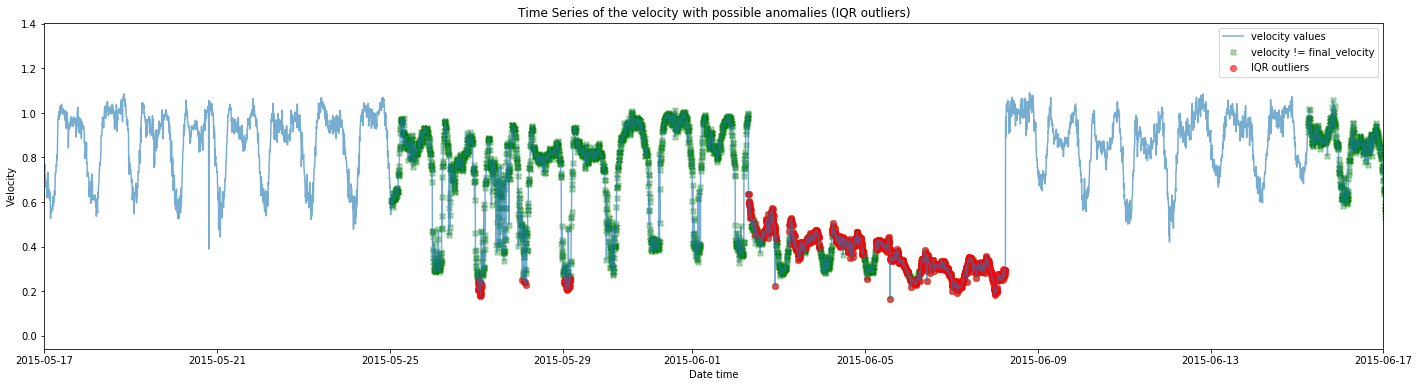

In [22]:
'''plot initial values with possible data loss or inconsistency'''
'''detailed view, 1 random month, where velocity!=final_velocity'''
'''velocity'''

pd.plotting.register_matplotlib_converters()  # needed to plot timestamps
plt.subplots(figsize=(24,6))

plt.plot(total.time, total.velocity,alpha=0.6, label="velocity values")
plt.scatter("time", "velocity", data=total[total.velocity!=total.final_velocity], 
              marker="X", color='green', 
            label="velocity != final_velocity", alpha=0.3)#possible anomalies, where velocity!=final_velocity
plt.scatter(x='time', y='velocity', data=outliers, marker="o",
            color='red', label="IQR outliers", alpha=0.6)
plt.xlim('2015-05-17 00:00:00','2015-06-17 00:00:00') #adjustable
plt.xlabel('Date time')
plt.ylabel('Velocity')
plt.title('Time Series of the velocity with possible anomalies (IQR outliers)');
plt.legend(loc="best");

**Conclusions:**

- IQR method allows to identify 5% anomalies in the data. They are partually corresponding to the missed or corrected data in final_ columns.
- The metod allow to detect anomalies as outliers in the data, but no prediction is possible.

### Anomaly detection: ARIMA<a name="step3"></a>

In [23]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')

In [24]:
#prepare data in the format, apropriated for the model
#multiplicative seasonality is not appropriate for zero and negative values--> I change NAs to median

y = total[['time','velocity']].set_index("time")
y['velocity'].fillna(y['velocity'].median(), inplace=True)
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350784 entries, 2014-09-01 00:00:00 to 2017-12-31 23:55:00
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   velocity  350784 non-null  float64
dtypes: float64(1)
memory usage: 5.4 MB


In [ ]:
#check the data with plotting
#y.plot(figsize=(24,6), linewidth=0.5, alpha=0.5)
#plt.show()

In [25]:
y.index

DatetimeIndex(['2014-09-01 00:00:00', '2014-09-01 00:05:00',
               '2014-09-01 00:10:00', '2014-09-01 00:15:00',
               '2014-09-01 00:20:00', '2014-09-01 00:25:00',
               '2014-09-01 00:30:00', '2014-09-01 00:35:00',
               '2014-09-01 00:40:00', '2014-09-01 00:45:00',
               ...
               '2017-12-31 23:10:00', '2017-12-31 23:15:00',
               '2017-12-31 23:20:00', '2017-12-31 23:25:00',
               '2017-12-31 23:30:00', '2017-12-31 23:35:00',
               '2017-12-31 23:40:00', '2017-12-31 23:45:00',
               '2017-12-31 23:50:00', '2017-12-31 23:55:00'],
              dtype='datetime64[ns]', name='time', length=350784, freq=None)

In [26]:
#as big data stop model selection algorithm, i select 4 months to run model selection
train= y[pd.to_datetime('2015-02-01 00:00:00'):pd.to_datetime('2015-06-01 00:00:00')] #4 months
train

,velocity
time,
2015-02-01 00:00:00,0.9000
2015-02-01 00:05:00,0.8712
2015-02-01 00:10:00,0.8109
2015-02-01 00:15:00,0.8253
2015-02-01 00:20:00,0.8361
...,...
2015-05-31 23:40:00,0.7902
2015-05-31 23:45:00,0.7605
2015-05-31 23:50:00,0.7425


In [27]:
#As we know thta the data have a seasonal trends
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

warnings.filterwarnings("ignore") # specify to ignore warning messages
aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            aic.append(results.aic)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:91152.6606418708
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:46681.306749859694
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-77454.50257157502
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-79217.92913224464
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-77517.86951245951
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-79338.62627540357
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-79516.70546048465
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-79562.37142668151
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:44940.04158347263
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3639.6377960673462
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-102150.47222394247
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-102125.49113322268
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-102242.92677282804
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-102262.23162739532
ARIMA(0, 0, 1)x(1,

In [28]:
#selecting model: 12-03-->12.23 #runs ca.20min
# minimal AIC:
print("minimal AIC: {}".format(min(aic))) #ARIMA(1, 1, 1)x(0, 0, 0, 12)12

minimal AIC: -149381.2966213056


In [29]:
#selected the best model is ARIMA(1, 1, 1)x(0, 0, 0, 12)12 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False, trend='c')

results = mod.fit()
results

In [30]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.818e-06   2.22e-05     -0.172      0.863   -4.73e-05    3.97e-05
ar.L1          0.3476      0.002    199.604      0.000       0.344       0.351
ma.L1         -0.5690      0.002   -331.936      0.000      -0.572      -0.566
sigma2         0.0009   3.96e-07   2281.876      0.000       0.001       0.001


In [31]:
#results.plot_diagnostics(figsize=(15, 12))
#plt.show()

In [32]:
# Make in-sample prediction and 
#prepare joint table with y values:
df_predicted=results.get_prediction(dynamic=False).summary_frame(alpha=0.1).merge(y, left_index=True, right_index=True)
df_predicted

,mean,mean_se,mean_ci_lower,mean_ci_upper,velocity
2014-09-01 00:00:00,0.000000,1414.213562,-2326.174307,2326.174307,0.8883
2014-09-01 00:05:00,1.042669,1029.758403,-1692.759174,1694.844513,0.8856
2014-09-01 00:10:00,0.884658,0.034601,0.827744,0.941572,0.8379
2014-09-01 00:15:00,0.841415,0.031242,0.790027,0.892803,0.8514
2014-09-01 00:20:00,0.850824,0.030429,0.800773,0.900875,0.8487
...,...,...,...,...,...
2017-12-31 23:35:00,0.787581,0.030074,0.738114,0.837048,0.7056
2017-12-31 23:40:00,0.725653,0.030074,0.676186,0.775120,0.8316
2017-12-31 23:45:00,0.815108,0.030074,0.765641,0.864575,0.8145
2017-12-31 23:50:00,0.808899,0.030074,0.759432,0.858366,0.8073


In [33]:
#check for the duplicates
df_predicted.duplicated().sum()

0

In [34]:
#create column 'anomaly' (all the points out of Confidence interval)
df_predicted['anomaly'] = 0
df_predicted.loc[df_predicted.velocity>df_predicted.mean_ci_upper, 'anomaly']=1
df_predicted.loc[df_predicted.velocity<df_predicted.mean_ci_lower, 'anomaly']=-1
#anomaly counts:
df_predicted.anomaly.value_counts()

 0    325403
-1     13779
 1     11602
Name: anomaly, dtype: int64

In [35]:
#how many anomalies detected (in %):
print("Percent of detected anomalies comprises {}%".format(
    round(df_predicted[df_predicted.anomaly!=0].shape[0]/len(df_predicted)*100,1)))

Percent of detected anomalies comprises 7.2%


In [36]:
df_predicted.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,velocity,anomaly
2014-09-01 00:00:00,0.000000,1414.213562,-2326.174307,2326.174307,0.8883,0
2014-09-01 00:05:00,1.042669,1029.758403,-1692.759174,1694.844513,0.8856,0
2014-09-01 00:10:00,0.884658,0.034601,0.827744,0.941572,0.8379,0
2014-09-01 00:15:00,0.841415,0.031242,0.790027,0.892803,0.8514,0
2014-09-01 00:20:00,0.850824,0.030429,0.800773,0.900875,0.8487,0


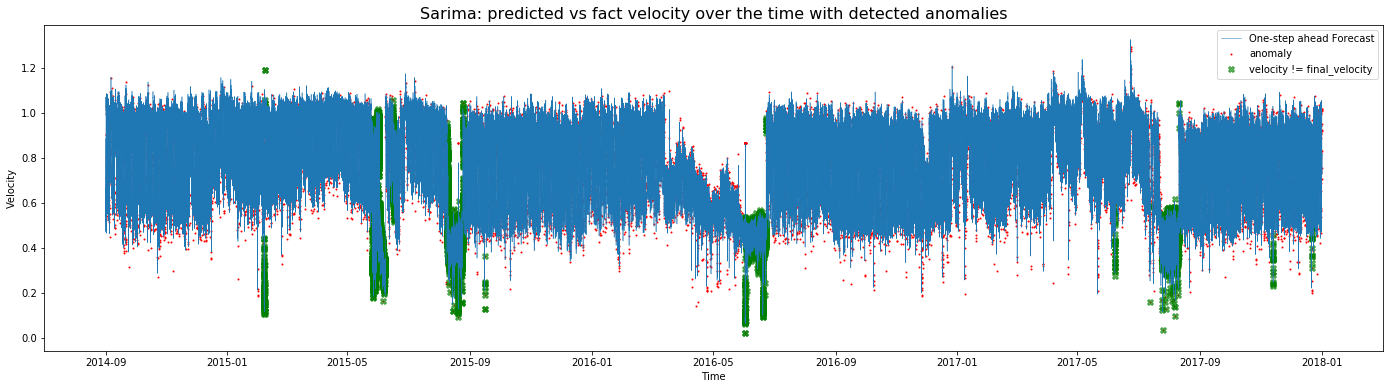

In [37]:
'''Plot predictions of Sarima model'''
'''velocity'''

plt.subplots(figsize=(24,6))

#plt.scatter(df_predicted.index, df_predicted["velocity"], s=0.5, color='grey', alpha=0.6, label='Observed')#Observed data

# Shade uncertainty area
#plt.fill_between(df_predicted[2:].index, df_predicted[2:]["mean_ci_upper"],
#                 df_predicted[2:]["mean_ci_lower"], alpha=0.7, 
#                 label="Prediction CI")                    # Predicted CI

plt.plot(df_predicted[2:].index, df_predicted[2:]["mean"],  '-', linewidth=0.5, label='One-step ahead Forecast') #Prediction

plt.scatter( df_predicted[2:][ df_predicted[2:]["anomaly"]!=0].index,  
            df_predicted[2:][ df_predicted[2:]["anomaly"]!=0]["velocity"], 
            s=1, color='red', label='anomaly')      #Plot anomalies according to the Arima model#

plt.scatter(x='time', y='velocity', data=total[total.velocity!=total.final_velocity], 
              marker="X",  color='green', label="velocity != final_velocity", alpha=0.6) # manual correction

#plt.xlim(pd.to_datetime('2015-05-01 00:00:00'), pd.to_datetime('2015-06-1 00:00:00') ) # adjust: plot date interval
plt.title('Sarima: predicted vs fact velocity over the time with detected anomalies', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend(loc="best")
plt.show()

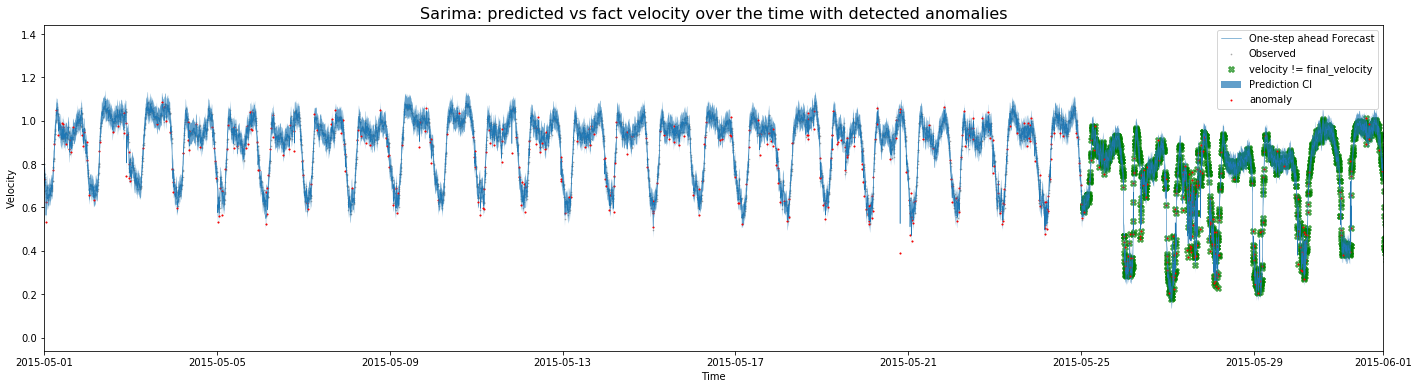

In [38]:
'''Plot predictions of Sarima model, close up'''
'''velocity'''

plt.subplots(figsize=(24,6))

plt.scatter(df_predicted.index, df_predicted["velocity"], s=0.5, color='grey', alpha=0.6, label='Observed')#Observed data
#plt.plot(train.index, train,   marker=".", alpha=0.3, color="black",  label='Observed')
# Shade uncertainty area
plt.scatter(x='time', y='velocity', data=total[total.velocity!=total.final_velocity], 
              marker="X",  color='green', label="velocity != final_velocity", alpha=0.6) # manual correction
plt.fill_between(df_predicted[2:].index, df_predicted[2:]["mean_ci_upper"],
                 df_predicted[2:]["mean_ci_lower"], alpha=0.7, 
                 label="Prediction CI")                    # Predicted CI

plt.plot(df_predicted[2:].index, df_predicted[2:]["mean"],  '-', linewidth=0.5, label='One-step ahead Forecast') #Prediction

plt.scatter( df_predicted[2:][ df_predicted[2:]["anomaly"]!=0].index,  
            df_predicted[2:][ df_predicted[2:]["anomaly"]!=0]["velocity"], 
            s=1, color='red', label='anomaly')      #Plot anomalies according to the Arima model#

plt.xlim(pd.to_datetime('2015-05-01 00:00:00'), pd.to_datetime('2015-06-1 00:00:00') ) # adjust: plot date interval
plt.title('Sarima: predicted vs fact velocity over the time with detected anomalies', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend(loc="best")
plt.show()

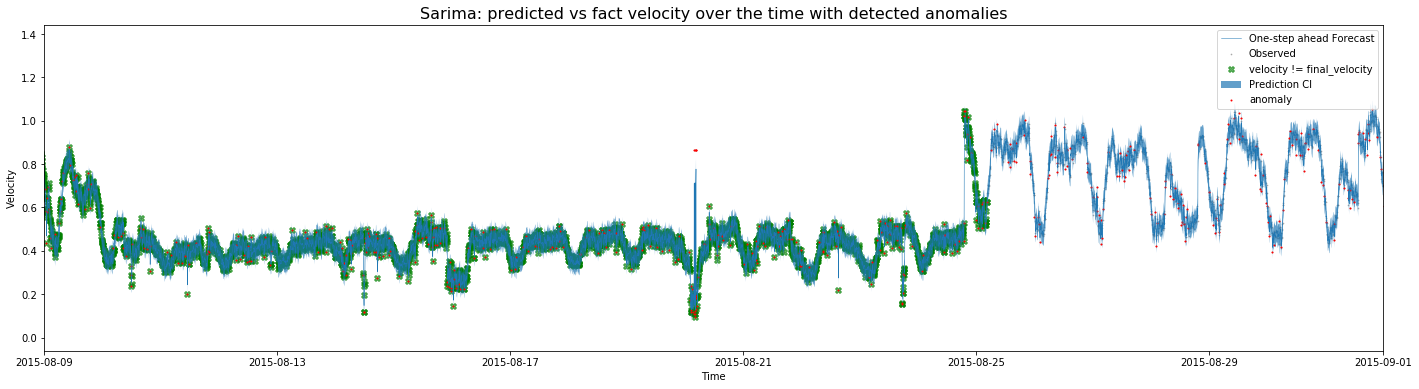

In [39]:
'''Plot predictions of Sarima model, close up'''
'''velocity'''

plt.subplots(figsize=(24,6))

plt.scatter(df_predicted.index, df_predicted["velocity"], s=0.5, color='grey', alpha=0.6, label='Observed')#Observed data
#plt.plot(train.index, train,   marker=".", alpha=0.3, color="black",  label='Observed')
# Shade uncertainty area
plt.scatter(x='time', y='velocity', data=total[total.velocity!=total.final_velocity], 
              marker="X",  color='green', label="velocity != final_velocity", alpha=0.6) # manual correction
plt.fill_between(df_predicted[2:].index, df_predicted[2:]["mean_ci_upper"],
                 df_predicted[2:]["mean_ci_lower"], alpha=0.7, 
                 label="Prediction CI")                    # Predicted CI

plt.plot(df_predicted[2:].index, df_predicted[2:]["mean"],  '-', linewidth=0.5, label='One-step ahead Forecast') #Prediction

plt.scatter( df_predicted[2:][ df_predicted[2:]["anomaly"]!=0].index,  
            df_predicted[2:][ df_predicted[2:]["anomaly"]!=0]["velocity"], 
            s=1, color='red', label='anomaly')      #Plot anomalies according to the Arima model#

plt.xlim(pd.to_datetime('2015-08-09 00:00:00'), pd.to_datetime('2015-09-01 00:00:00') ) # adjust: plot date interval
plt.title('Sarima: predicted vs fact velocity over the time with detected anomalies', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend(loc="best")
plt.show()

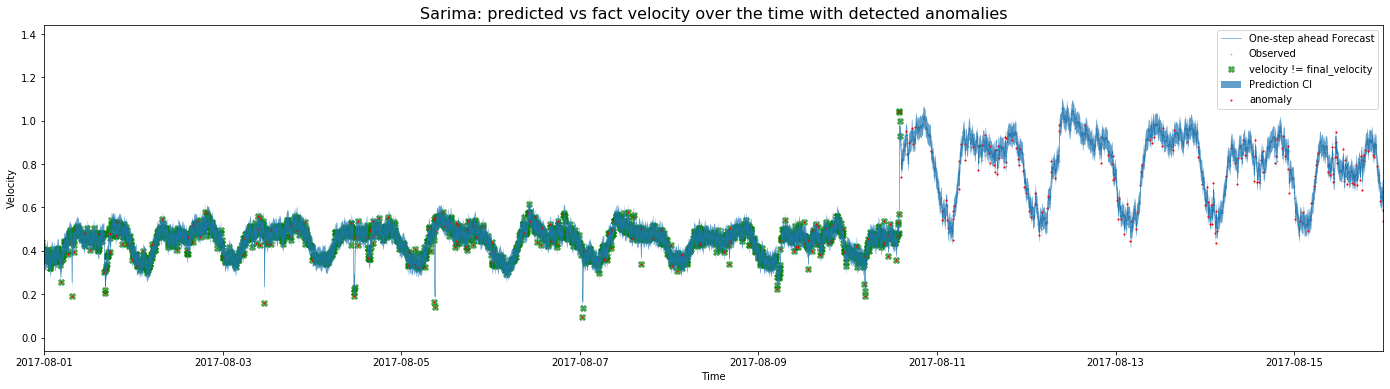

In [40]:
'''Plot predictions of Sarima model, close up'''
'''velocity'''

plt.subplots(figsize=(24,6))

plt.scatter(df_predicted.index, df_predicted["velocity"], s=0.5, color='grey', alpha=0.6, label='Observed')#Observed data
#plt.plot(train.index, train,   marker=".", alpha=0.3, color="black",  label='Observed')
# Shade uncertainty area
plt.scatter(x='time', y='velocity', data=total[total.velocity!=total.final_velocity], 
              marker="X",  color='green', label="velocity != final_velocity", alpha=0.6) # manual correction
plt.fill_between(df_predicted[2:].index, df_predicted[2:]["mean_ci_upper"],
                 df_predicted[2:]["mean_ci_lower"], alpha=0.7, 
                 label="Prediction CI")                    # Predicted CI

plt.plot(df_predicted[2:].index, df_predicted[2:]["mean"],  '-', linewidth=0.5, label='One-step ahead Forecast') #Prediction

plt.scatter( df_predicted[2:][ df_predicted[2:]["anomaly"]!=0].index,  
            df_predicted[2:][ df_predicted[2:]["anomaly"]!=0]["velocity"], 
            s=1, color='red', label='anomaly')      #Plot anomalies according to the Arima model#

plt.xlim(pd.to_datetime('2017-08-01 00:00:00'), pd.to_datetime('2017-08-16 00:00:00') ) # adjust: plot date interval

plt.title('Sarima: predicted vs fact velocity over the time with detected anomalies', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend(loc="best")
plt.show()

In [41]:
# The mean square error(Sarima)

mse = ((df_predicted["velocity"]-df_predicted["mean"]) ** 2).mean()
print('The Mean Squared Error of Arima prediction is {}'.format(round(mse, 4)))
print('The Mean Absolute Error of Arima prediction is {}'.format(round((df_predicted["velocity"]-df_predicted["mean"]).mean(), 4)))

The Mean Squared Error of Arima prediction is 0.0009
The Mean Absolute Error of Arima prediction is 0.0


In [42]:
# The mean absolur error (Sarima)

print('MAPE (mean absolute error in percent) – ', 
      round(np.mean(abs((df_predicted["mean"]-df_predicted["velocity"])*100/df_predicted["velocity"])),2),'%')
print('MAE (mean absolute error) – ', round(np.mean(abs(df_predicted["velocity"]-df_predicted["mean"])),2))

MAPE (mean absolute error in percent) –  2.51 %
MAE (mean absolute error) –  0.02


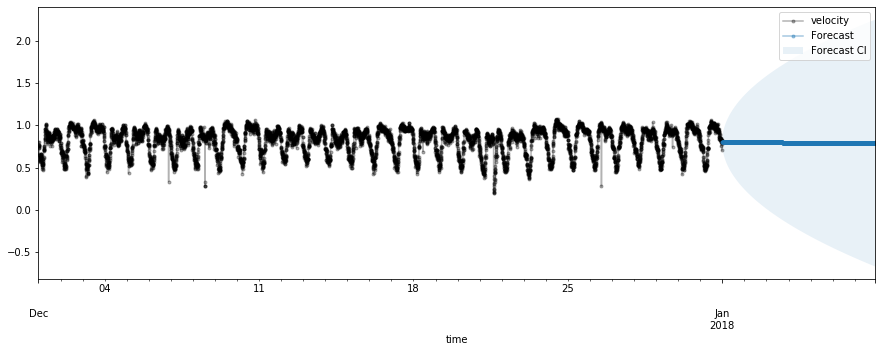

In [43]:
'''Plot forecast for Sarima model'''
'''velocity'''

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)

#plt.scatter(y.index, y, s=1, color='grey', label='Observed',ax=ax)
y['2017-12-01 00:00:00':].plot(label='Observed', marker=".", alpha=0.3, color="black",ax=ax)

fcast = results.get_forecast(2000).summary_frame(alpha=0.1)
fcast['mean'].plot(ax=ax, marker=".",  alpha=.4, label="Forecast")#style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], alpha=0.1, label="Forecast CI")
plt.legend();

**Conclusions:**

- Arima(SARIMA, seasonal Arima) model allows to identify 7.2% anomalies in the data. They are partually corresponding to the missed or corrected data in final_ columns.
- The Mean error is not too high(MSE=0.0009, MAPE=2.6%), but predictions look as very overfitted and forecast is not presise.

### Anomaly detection: Prophet<a name="step4"></a>

In [44]:
#install packages for anomaly detection and value prediction
#conda install -c conda-forge pystan
#conda install -c conda-forge fbprophet

In [45]:
from datetime import date 
import holidays 

from fbprophet import Prophet

from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

In [46]:
#adaptation of the df to the prophet
df_velocity = pd.DataFrame()

In [47]:
#re-name dataset for prophet format
df_velocity["ds"]= total.time
df_velocity["y"]= total.velocity

In [48]:
df_velocity.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [49]:
df_velocity

,ds,y
0,2014-09-01 00:00:00,0.8883
1,2014-09-01 00:05:00,0.8856
2,2014-09-01 00:10:00,0.8379
3,2014-09-01 00:15:00,0.8514
4,2014-09-01 00:20:00,0.8487
...,...,...
350779,2017-12-31 23:35:00,0.7056
350780,2017-12-31 23:40:00,0.8316
350781,2017-12-31 23:45:00,0.8145
350782,2017-12-31 23:50:00,0.8073


In [50]:
df_velocity.info() #Prophet accept data with NA, therefore I didnt replace NAs here

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350784 entries, 0 to 350783
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      350784 non-null  datetime64[ns]
 1   y       350679 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 MB


In [51]:
# Checking the model for the adjusted period(here for 1 year)
predictions = 365

# cut out last n observations (=predictions) from the initial dataset to test model quality
train_df = df_velocity[:-predictions]
train_df.shape

(350419, 2)

In [52]:
m = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True) #as we know yet about seasonability

In [53]:
m.fit(train_df, iter=100) #fitting model with 100 iteration require ca. 5-7 min (default iteration ca.3h)

In [54]:
future = m.make_future_dataframe(periods=predictions) #can change time period
future.shape, future.head()

((350784, 1),                    ds
 0 2014-09-01 00:00:00
 1 2014-09-01 00:05:00
 2 2014-09-01 00:10:00
 3 2014-09-01 00:15:00
 4 2014-09-01 00:20:00)

In [55]:
forecast = m.predict(future)#predicting with 100 iteration require ca. 3-4 min
forecast.shape

(350784, 22)

In [56]:
forecast.head() 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-09-01 00:00:00,0.884041,0.638318,0.910133,0.884041,0.884041,-0.114968,-0.114968,-0.114968,-0.079449,...,0.009527,0.009527,0.009527,-0.045046,-0.045046,-0.045046,0.0,0.0,0.0,0.769073
1,2014-09-01 00:05:00,0.884041,0.625242,0.896443,0.884041,0.884041,-0.121234,-0.121234,-0.121234,-0.085697,...,0.009489,0.009489,0.009489,-0.045027,-0.045027,-0.045027,0.0,0.0,0.0,0.762807
2,2014-09-01 00:10:00,0.884040,0.620326,0.883453,0.884040,0.884040,-0.127474,-0.127474,-0.127474,-0.091919,...,0.009452,0.009452,0.009452,-0.045007,-0.045007,-0.045007,0.0,0.0,0.0,0.756566
3,2014-09-01 00:15:00,0.884039,0.621483,0.877143,0.884039,0.884039,-0.133684,-0.133684,-0.133684,-0.098109,...,0.009414,0.009414,0.009414,-0.044988,-0.044988,-0.044988,0.0,0.0,0.0,0.750356
4,2014-09-01 00:20:00,0.884039,0.616257,0.879219,0.884039,0.884039,-0.139855,-0.139855,-0.139855,-0.104262,...,0.009376,0.009376,0.009376,-0.044969,-0.044969,-0.044969,0.0,0.0,0.0,0.744183


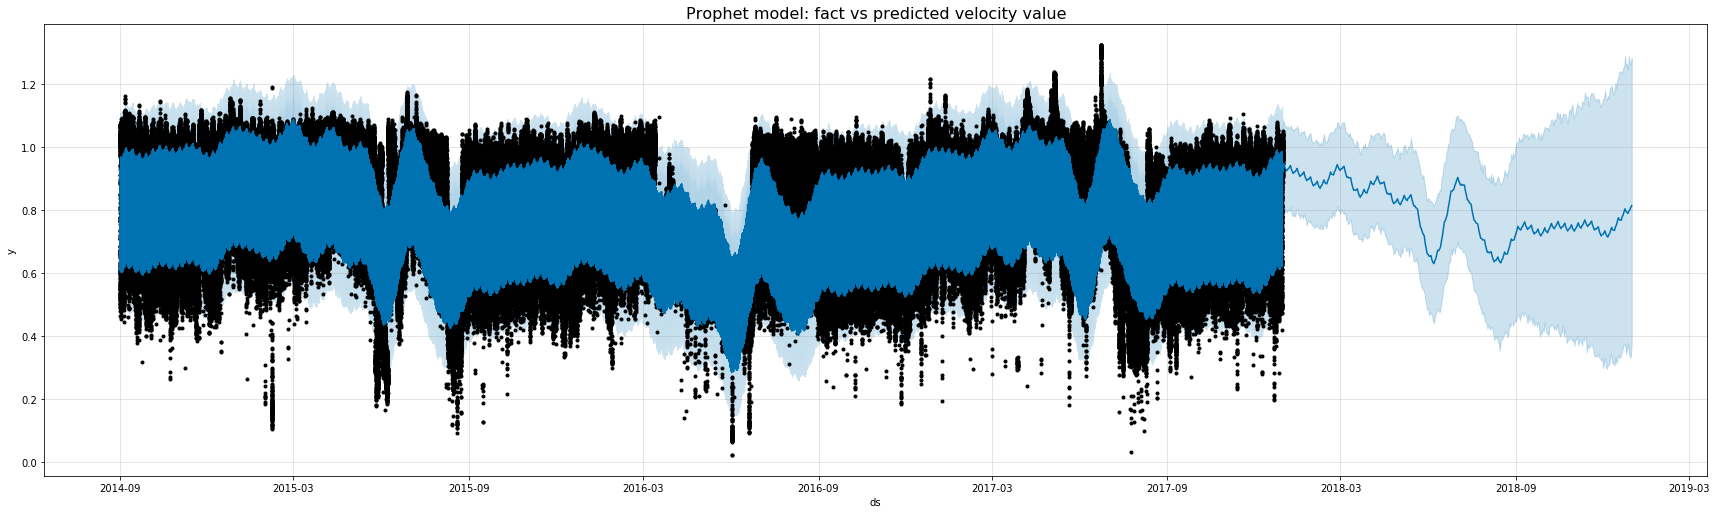

In [57]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

'''Prophet: plot fact values vs predicted values, and their confidence interval'''
'''velocity'''

fig1 = m.plot(forecast,  figsize=(24,7))
plt.title('Prophet model: fact vs predicted velocity value', fontsize=16);

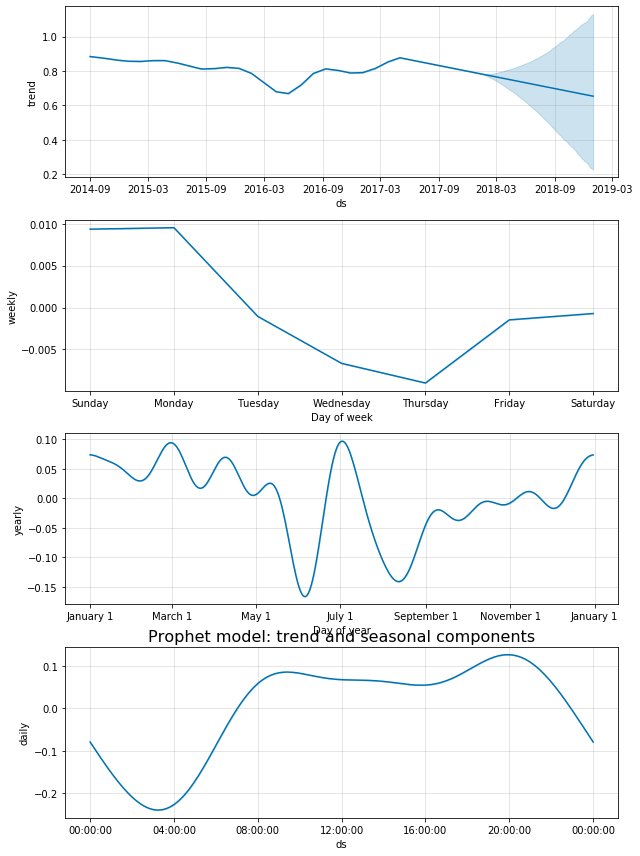

In [58]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

'''Prophet: plot seasonal trends'''
'''velocity'''

fig2 = m.plot_components(forecast)
plt.title('Prophet model: trend and seasonal components', fontsize=16);

In [59]:
#prepare joint table
df_predict= forecast[['ds','trend','yhat', 'yhat_lower', 'yhat_upper']].copy()

df_predict = df_predict.merge(total[["velocity", "time"]], left_on="ds",
    right_on="time")
df_predict.head()

,ds,trend,yhat,yhat_lower,yhat_upper,velocity,time
0,2014-09-01 00:00:00,0.884041,0.769073,0.638318,0.910133,0.8883,2014-09-01 00:00:00
1,2014-09-01 00:05:00,0.884041,0.762807,0.625242,0.896443,0.8856,2014-09-01 00:05:00
2,2014-09-01 00:10:00,0.884040,0.756566,0.620326,0.883453,0.8379,2014-09-01 00:10:00
3,2014-09-01 00:15:00,0.884039,0.750356,0.621483,0.877143,0.8514,2014-09-01 00:15:00
4,2014-09-01 00:20:00,0.884039,0.744183,0.616257,0.879219,0.8487,2014-09-01 00:20:00


In [60]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350420 entries, 0 to 350419
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ds          350420 non-null  datetime64[ns]
 1   trend       350420 non-null  float64       
 2   yhat        350420 non-null  float64       
 3   yhat_lower  350420 non-null  float64       
 4   yhat_upper  350420 non-null  float64       
 5   velocity    350315 non-null  float64       
 6   time        350420 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(5)
memory usage: 21.4 MB


In [61]:
#create column 'anomaly' (all the points out of the yhat_lower or yhat_upper)
df_predict['anomaly'] = 0
df_predict.loc[df_predict.velocity>df_predict.yhat_upper, 'anomaly']=1
df_predict.loc[df_predict.velocity<df_predict.yhat_lower, 'anomaly']=-1
df_predict.anomaly.value_counts()

 0    282049
-1     37437
 1     30934
Name: anomaly, dtype: int64

In [62]:
#how many anomalies detected (in%):
print("Percent of detected anomalies comprises {}%".format(
    round(df_predict[df_predict.anomaly!=0].shape[0]/len(df_predict)*100,1)))

Percent of detected anomalies comprises 19.5%


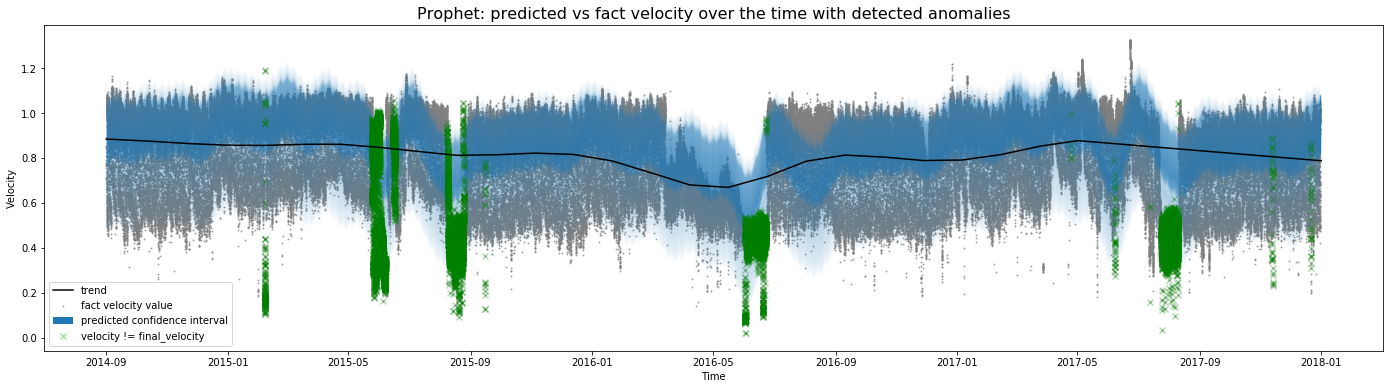

In [63]:
'''Prophet: plotting prediction comparing to fact values'''
'''velocity'''

#pd.plotting.register_matplotlib_converters()  # needed to plot timestamps

plt.subplots(figsize=(24,6))

plt.scatter(df_predict.ds, df_predict.velocity, s=1, color='grey', alpha=.6, label='fact velocity value')
plt.plot(df_predict.ds, df_predict.trend, '-', color= "black", label='trend')
#plt.plot(df_predicted.ds, df_predicted.yhat_upper, '--', color= "blue", alpha=0.2, label='predicted upper')
#plt.plot(df_predicted.ds, df_predicted.yhat_lower, '--', color= "blue", alpha=0.2, label='predicted lower')
plt.fill_between(df_predict.ds, df_predict.yhat_upper,df_predict.yhat_lower, 
                # alpha=0.9, 
                 label="predicted confidence interval")#fill ci
#plt.plot(df_predicted.ds, df_predicted.yhat, '-', color= "blue", label='predicted value')
#plt.scatter("ds", "fact", data=df_predicted[df_predicted.anomaly!=0], s=1, color='red', label='anomaly')
plt.scatter(x='time', y='velocity', data=total[total.velocity!=total.final_velocity], 
              marker="x", color='green', label="velocity != final_velocity", alpha=0.3)
plt.title('Prophet: predicted vs fact velocity over the time with detected anomalies', fontsize=16)
plt.xlabel('Time')
#plt.xlim('2014-09-01 00:00:00', '2014-10-01 00:00:00')
plt.ylabel('Velocity')
plt.legend(loc="best")
plt.show()

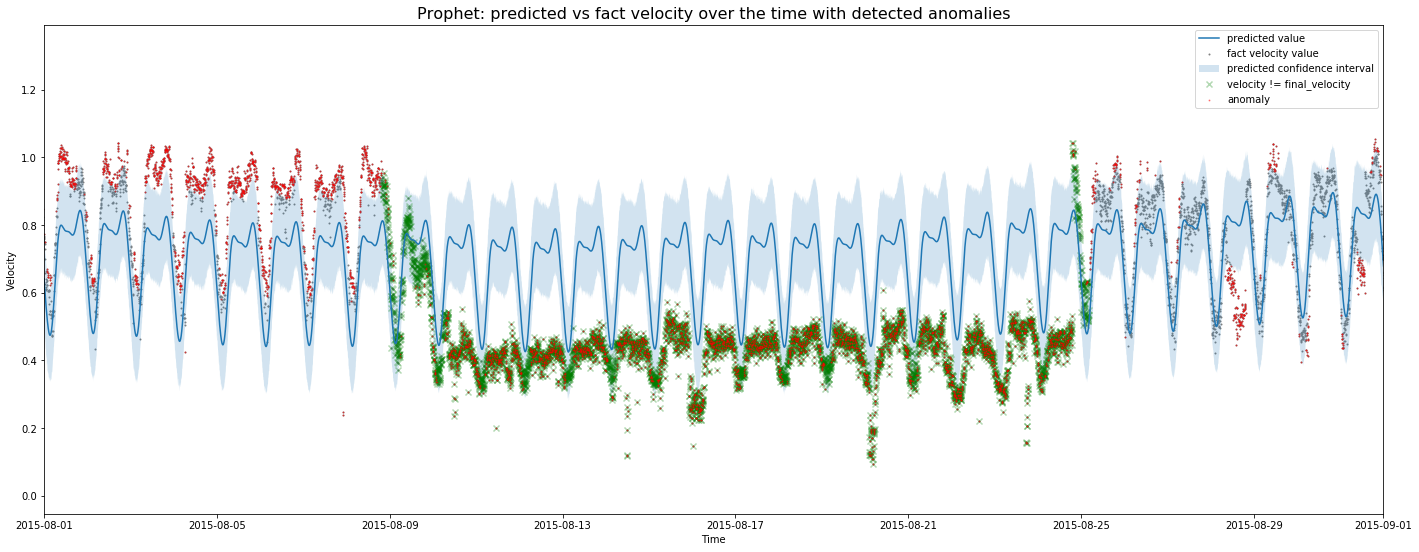

In [64]:
'''Prophet: plotting prediction comparing to fact values'''
'''close look for 1 month'''
'''velocity'''

pd.plotting.register_matplotlib_converters()  # needed to plot timestamps

plt.subplots(figsize=(24,9))

plt.scatter(df_predict.ds, df_predict.velocity, s=1, color='grey', label='fact velocity value')
plt.fill_between(df_predict.ds, df_predict.yhat_upper,df_predict.yhat_lower,alpha=0.2, 
                 label="predicted confidence interval")#fill ci
plt.plot(df_predict.ds, df_predict.yhat, '-',  label='predicted value')

plt.scatter(x='time', y='velocity', data=total[total.velocity!=total.final_velocity], 
              marker="x",  color='green', label="velocity != final_velocity", alpha=0.3)#
plt.scatter("ds", "velocity", data=df_predict[df_predict.anomaly!=0], s=1, alpha=.4,color='red', label='anomaly')

plt.title('Prophet: predicted vs fact velocity over the time with detected anomalies', fontsize=16)
plt.xlabel('Time')
plt.xlim('2015-08-01 00:00:00', '2015-09-01 00:00:00') #adjustable
plt.ylabel('Velocity')
plt.legend(loc="best")
plt.show()

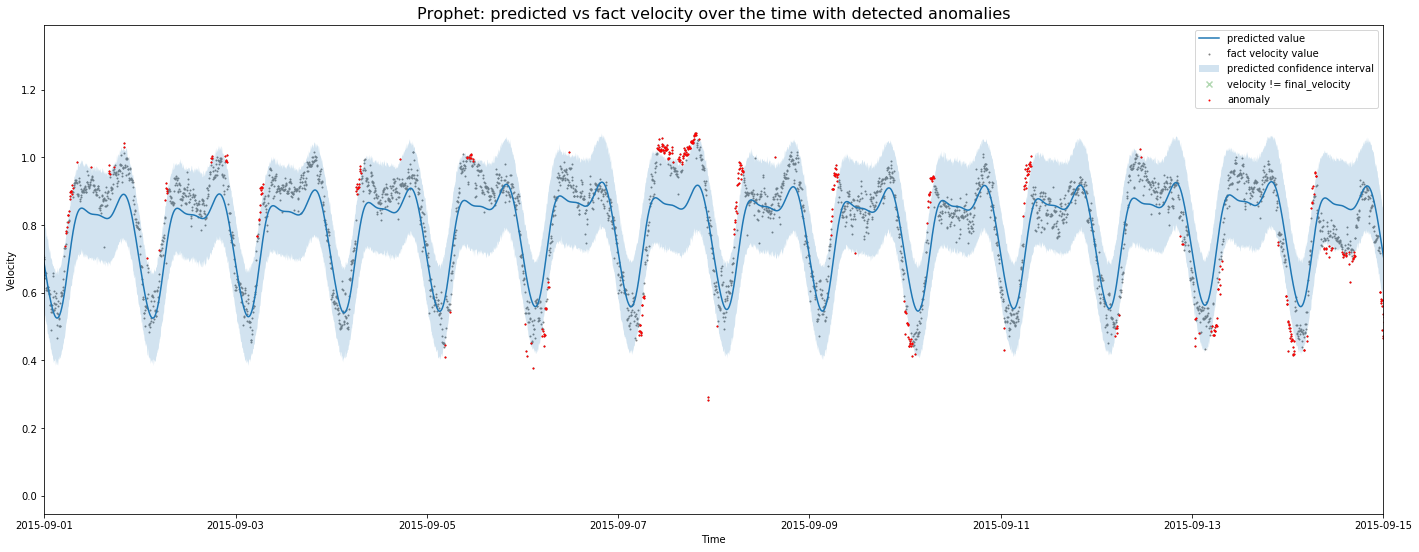

In [65]:
'''Prophet: plotting prediction comparing to fact values'''
'''close look for 1/2 month'''
'''velocity'''

pd.plotting.register_matplotlib_converters()  # needed to plot timestamps

plt.subplots(figsize=(24,9))

plt.scatter(df_predict.ds, df_predict.velocity, s=1, color='grey', label='fact velocity value')
plt.fill_between(df_predict.ds, df_predict.yhat_upper,df_predict.yhat_lower,alpha=0.2, 
                 label="predicted confidence interval")#fill ci
plt.plot(df_predict.ds, df_predict.yhat, '-',  label='predicted value')
plt.scatter(x='time', y='velocity', data=total[total.velocity!=total.final_velocity], 
              marker="x",  color='green', label="velocity != final_velocity", alpha=0.3)#
plt.scatter("ds", "velocity", data=df_predict[df_predict.anomaly!=0], s=1, color='red', label='anomaly')
plt.title('Prophet: predicted vs fact velocity over the time with detected anomalies', fontsize=16)
plt.xlabel('Time')
plt.xlim('2015-09-01 00:00:00', '2015-09-15 00:00:00') #ajustable
plt.ylabel('Velocity')
plt.legend(loc="best")
plt.show()

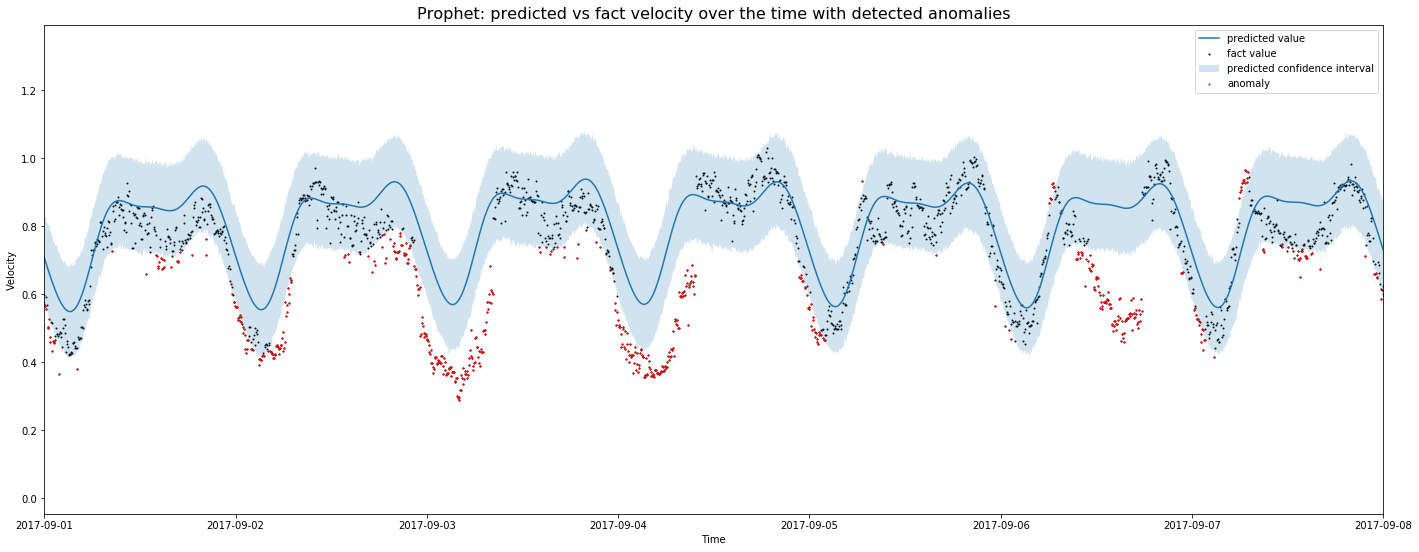

In [66]:
'''Prophet: plotting prediction comparing to fact values'''
'''close look for 1 week'''
'''velocity'''

pd.plotting.register_matplotlib_converters()  # needed to plot timestamps

plt.subplots(figsize=(24,9))

plt.scatter(df_predict.ds, df_predict.velocity, s=1, color='black', label='fact value')
#plt.plot(df_predicted.ds, df_predicted.trend, '-', color= "black", label='trend')
plt.fill_between(df_predict.ds, df_predict.yhat_upper,df_predict.yhat_lower,alpha=0.2, 
                 label="predicted confidence interval")#fill ci
plt.plot(df_predict.ds, df_predict.yhat, '-',  label='predicted value')
plt.scatter("ds", "velocity", data=df_predict[df_predict.anomaly!=0], s=1, color='red', label='anomaly')

plt.title('Prophet: predicted vs fact velocity over the time with detected anomalies', fontsize=16)
plt.xlabel('Time')

plt.xlim('2017-09-01 00:00:00', '2017-09-08 00:00:00') #adjustable
plt.ylabel('Velocity')
plt.legend(loc="best")
plt.show()

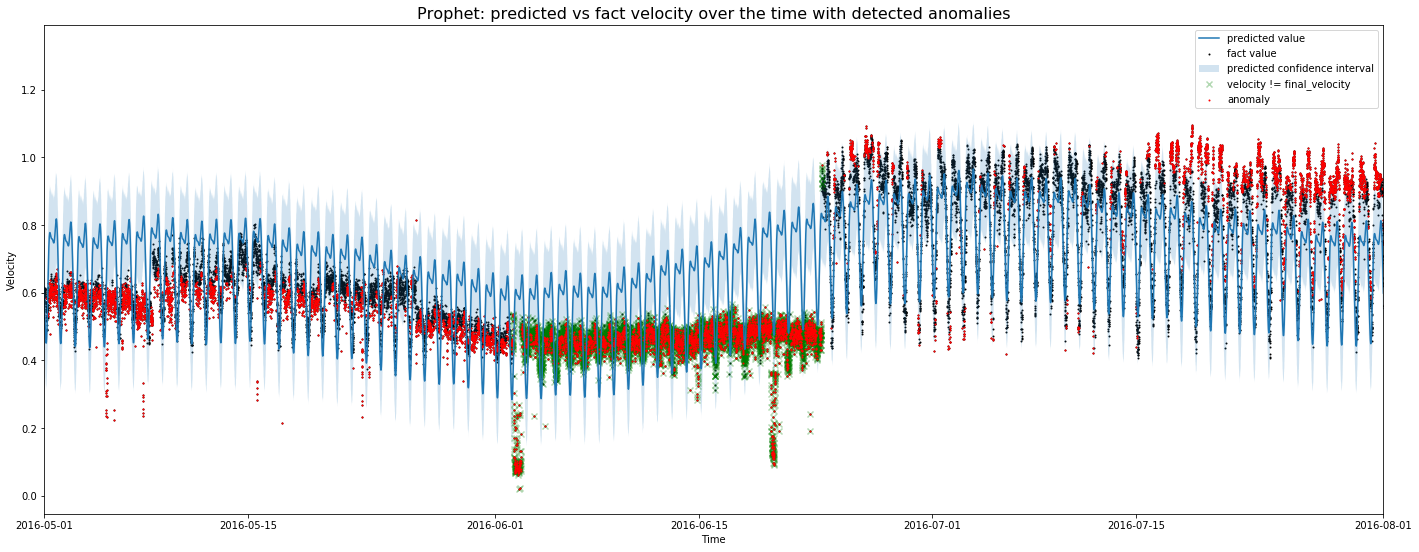

In [67]:
'''Prophet: plotting prediction comparing to fact values'''
'''close look for period with obvious anomaly'''
'''velocity'''


pd.plotting.register_matplotlib_converters()  # needed to plot timestamps

plt.subplots(figsize=(24,9))

plt.scatter(df_predict.ds, df_predict.velocity, s=1, color='black', label='fact value')
#plt.plot(df_predicted.ds, df_predicted.trend, '-', color= "black", label='trend')

plt.fill_between(df_predict.ds, df_predict.yhat_upper,df_predict.yhat_lower, alpha=0.2, 
                 label="predicted confidence interval")#fill ci
plt.plot(df_predict.ds, df_predict.yhat, '-',  label='predicted value')
plt.scatter(x='time', y='velocity', data=total[total.velocity!=total.final_velocity], 
              marker="x",  color='green', label="velocity != final_velocity", alpha=0.3)#
plt.scatter("ds", "velocity", data=df_predict[df_predict.anomaly!=0], s=1, color='red', label='anomaly')

plt.title('Prophet: predicted vs fact velocity over the time with detected anomalies', fontsize=16)
plt.xlabel('Time')

plt.xlim('2016-05-01 00:00:00','2016-08-01 00:00:00') #adjustable
plt.ylabel('Velocity')
plt.legend(loc="best")
plt.show()

In [68]:
# Model errors (mean absolute error)
cmp_df = df_predict.copy()
cmp_df['e'] = cmp_df['velocity'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['velocity']
print('MAPE (mean absolute error in percent) – ', round(np.mean(abs(cmp_df[-predictions:]['p'])),1),'%')
print('MAE (mean absolute error) – ', round(np.mean(abs(cmp_df[-predictions:]['e'])),2))

MAPE (mean absolute error in percent) –  9.6 %
MAE (mean absolute error) –  0.07


In [70]:
# The mean square error
mse = ((df_predict["yhat"]-df_predict["velocity"]) ** 2).mean()
print('The Mean Squared Error of Prophet prediction is {}'.format(round(mse, 4)))
print('The Mean Absolute Error of Prophet prediction is {}'.format(round((df_predict["yhat"]-df_predict["velocity"]).mean(), 4)))

The Mean Squared Error of Prophet prediction is 0.0134
The Mean Absolute Error of Prophet prediction is 0.0045


**Conclusions:**  

- The Prophet model allow to refer 19.5% of the initial data to anomalies. They are partually corresponding to the missed or corrected data in final_ columns

- The mean error is higher than those in Sarima (MSE=0.07, MAPE=9.6%), but data do not looks overfitted, and reasonably accounting daily and seasonal fluctuations.

- The Prophet model show the seasonal trends, which are in correspondence with those, performed with EDA. Short description:
    
    -yearly: there were some fluctuation within a year, but after 2017 it predicted to be slowly decreasing
    
    -montly: there are some peaks, highest in July with 2 main descreases in June and August 
    
    -weekly: velocity at Sunday-Monday lay at some high plateu, which decreases up to Thursday, and then growing again up to Sunday plateu 
    
    -daily: the minimal values per day are registered at 4AM, then follow signal uprise and after 8AM its come to platoe. after 4PM its rising to 8PM and after that decreasing upt to its minimun at 4AM. This trend is exactly like for level

#### General Conclusions:<a name="step7"></a>

- IQR method allows to identify 5% anomalies in the data, Sarima model 7.2% and Prophet model 19.5%. The detected anomalies are partually corresponding to the missed or corrected data in final_ columns.
- Prophet model reflects seasonal trends and adjust velocity fluctuation within a reasonable confidence interval. However having lower error, Sarima model looks overfitted and forecast velocity in a very wide interval. Therefore I would proceed future with Prophet model.